## Tutorial 1
### Practical deep learning

April 7th 2021

- what is the goal of these tutorials?
- the 3 part conceptual framework, data/model/training
- introduction to pytorch

the goal of the tutorials is to teach you the practical skills to apply these methods in your own research

please set yourself up with the software to run jupyter notebooks

https://www.anaconda.com/products/individual

you can run stuff online
https://colab.research.google.com/

but its really much better if you have the ability to run python on your computer
if you run into trouble, write us on the slack channel.


###  data/model/training

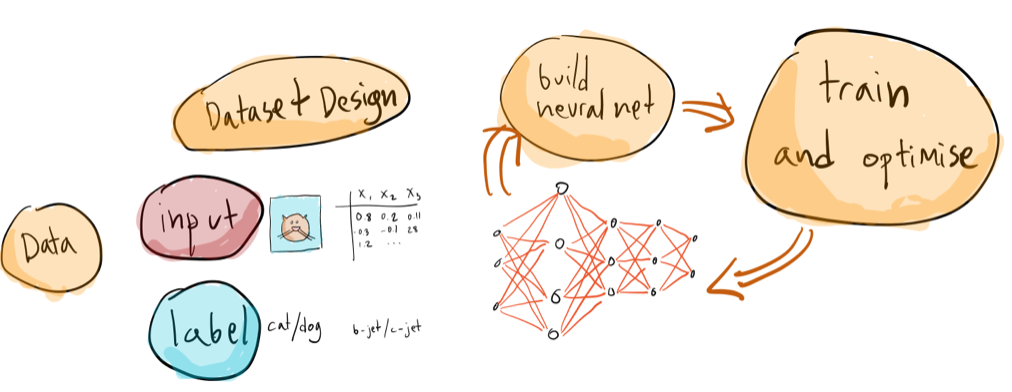

### Introduction to pytorch - a simple example from start to finish

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader

### training neural networks is actually fitting a function

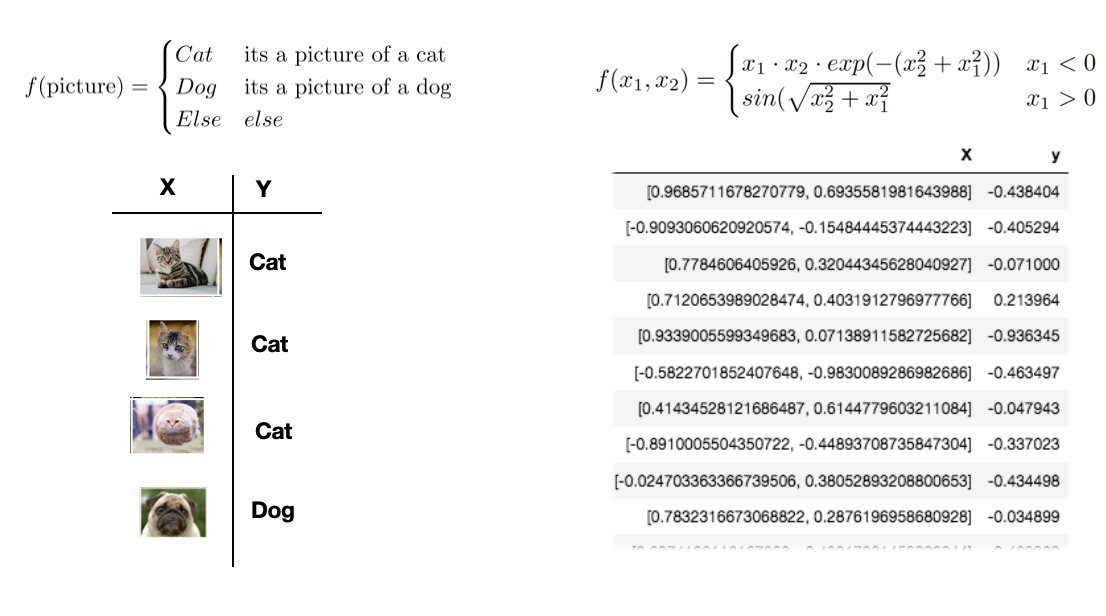

## our dataset

we create a function of two variables x1 and x2, that outputs one number

In [16]:
def func(x1_,x2_):
    if x1_ < 0:
        x1 = 2*( (x1_+1)*2-1 )
        x2 = 2*x2_
        return 3*x1*x2*np.exp(-x1**2-x2**2)-0.5
    else:
        x1 = 5*( x1_*2-1 )
        x2 = 5*x2_
        return np.sin(np.sqrt(x1**2+x2**2))

In [17]:
func(0.2,0.8)

-0.9589242746631385

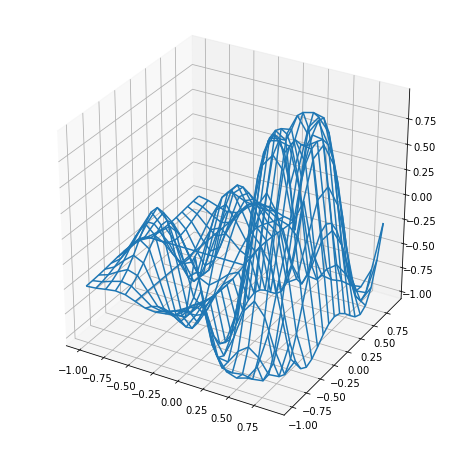

In [12]:
X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

Y = np.zeros(X1.shape)
for i, x1_i in enumerate(X1_):
    for j, x2_i in enumerate(X2_):
        Y[j][i] = func(x1_i,x2_i)
        
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)


plt.show()

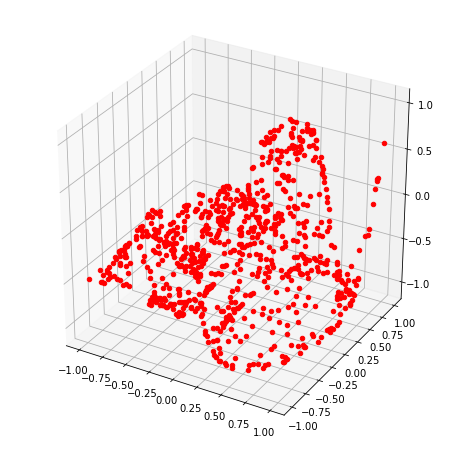

In [13]:
x1x2 = np.random.rand(10000,2)*2.0-1.0

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1,projection='3d')


for samp in x1x2[:800]:
    
    ax.scatter(samp[0],samp[1],func(samp[0],samp[1]),c='r')



plt.show()

## create our training dataset in the form of input X and output y

In [9]:
df = pd.DataFrame(x1x2,columns=['x1','x2'])

df['X'] = [ np.array([x1,x2]) for  x1,x2 in zip(df.x1,df.x2)  ]
df['y'] = [ func(x1,x2) for x1,x2 in zip(df.x1,df.x2) ]

df = df.drop('x1',axis=1).drop('x2',axis=1)
df

,X,y
0,"[-0.8888736943618725, 0.17425334598382625]",-0.628130
1,"[0.9848967713254551, 0.36824188629058896]",-0.889578
2,"[0.5657464074528611, -0.9589213648073998]",-0.991935
3,"[-0.2262566516853286, -0.8408942594376976]",-0.598453
4,"[0.4328512561684752, 0.7098014191768807]",-0.453225
...,...,...
9995,"[0.8080999441133159, -0.34245976067177053]",-0.373938
9996,"[0.9123031790588556, -0.1596316503372528]",-0.871368
9997,"[0.9558382596142239, 0.6925295612164764]",-0.530155
9998,"[0.547845213050792, -0.5620665573087515]",0.286741


# Data handling 

### Tensors, DataSets, and DataLoaders

here we create a 1d tensor of shape (2)

In [14]:
x = torch.FloatTensor([3.8,4.2])


print('x.shape ',x.shape)
print('x[0] ', x[0])
print('x[1] ', x[1])

x.shape  torch.Size([2])
x[0]  tensor(3.8000)
x[1]  tensor(4.2000)


### lets create our dataset for training

In [18]:
len_train = 9000

x_full = torch.FloatTensor(df.X)
y_full = torch.FloatTensor(df.y).view(len(df),1)

x_train = x_full[:len_train]
y_train = y_full[:len_train]

x_valid = x_full[len_train:]
y_valid = y_full[len_train:]

In [19]:
x_train.shape

torch.Size([9000, 2])

In [20]:
y_train.shape

torch.Size([9000, 1])

in pytorch, our data, in whatever form it has, goes through two objects, a dataset object and a dataloader object

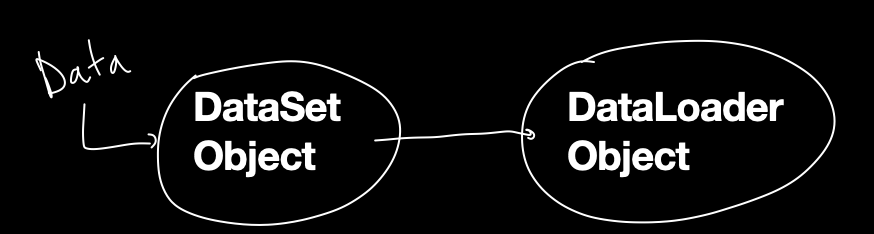

#### A Dataset object is basically a wrapper around our (x,y) pairs - if we ask for a particular index it will give us a single (x,y), we will learn to write custom dataset objects later in the course

In [21]:
train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

In [23]:
train_ds[42]

(tensor([0.1092, 0.0602]), tensor([-0.7019]))

## now lets create a dataloader

## a dataloader is used to batch together items for training, it returns multiple (x,y) every time you loop over it

In [26]:
dataloader = DataLoader(train_ds,batch_size=10,shuffle=True)

In [27]:
for x,y in dataloader:
    break
    
print(x.shape,y.shape)

torch.Size([10, 2]) torch.Size([10, 1])


# Model

### how to build a neural network?

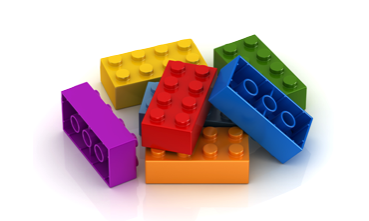

we built the network out of simple building blocks, each one has an input and an output, and we chain them together.

## pytorch basics: a layer

a layer takes input and gives some output, in this case, it takes in a tensor of shape (2) and outputs tensor of shape (10)

In [28]:
my_first_layer = nn.Linear(2,10)

x = torch.FloatTensor([3.8,4.2])

my_first_layer(x)

tensor([-2.3329e+00,  3.0604e+00,  7.7266e-01,  2.0629e-04,  6.6651e-01,
        -3.7208e+00, -2.4628e-01, -3.7243e-01, -3.8301e+00,  1.7259e+00],
       grad_fn=<AddBackward0>)

## an activation function

this object can take a torch tensor of arbitrary size, and apply some function to each of it's elements

we can chain these objects together, so we input x to our layer, and input the layer output to our activation function

In [29]:
activation1 = nn.ReLU()

activation1( my_first_layer(x) )

tensor([0.0000e+00, 3.0604e+00, 7.7266e-01, 2.0629e-04, 6.6651e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7259e+00],
       grad_fn=<ReluBackward0>)

## we can create another layer, and put everything together

this layer will take as input 10 numbers, and output 1 number
we created a function that takes us from two numbers to one number, just like our dataset requires

In [30]:
layer2 = nn.Linear(10,1)

layer2(activation1( my_first_layer(x) ))

tensor([0.6133], grad_fn=<AddBackward0>)

## important comment about batches and layers

notice that we showed layers taking a single input, but they are designed to take multiple inputs and return multiple outputs

In [31]:
x = torch.FloatTensor([[0.2,0.3],[0.4,0.6],[0.8,-0.2]])

print(' x.shape ',x.shape) #torch.Size([3, 2])

my_first_layer = nn.Linear(2,10)

out = my_first_layer(x)

print('out shape ',out.shape)

 x.shape  torch.Size([3, 2])
out shape  torch.Size([3, 10])


## what is in these layers?

these are "linear" layers
the first layer we created went from 2 numbers to 10 numbers
inside there is a 10x2 matrix and a vector of size 10
the values of these elements is randomly selected when we create the layer

In [32]:
for p in my_first_layer.parameters():
    print(p)
    print(p.shape)
    print('----------')

Parameter containing:
tensor([[-0.2105, -0.0131],
        [-0.6115, -0.7034],
        [ 0.5676, -0.4032],
        [ 0.5665,  0.5811],
        [-0.5353,  0.5278],
        [ 0.5680, -0.6551],
        [ 0.0795, -0.7005],
        [ 0.0402,  0.2735],
        [-0.4057, -0.3541],
        [ 0.3296,  0.0390]], requires_grad=True)
torch.Size([10, 2])
----------
Parameter containing:
tensor([-0.1958, -0.4904,  0.2375,  0.5582,  0.5587,  0.6298,  0.1510, -0.1179,
        -0.4101,  0.3181], requires_grad=True)
torch.Size([10])
----------


## creating a neural network object

in order to "train" our weights pytorch has a special structure for "models"
let's put our building blocks into a object like this:

In [33]:
#this code defines the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Linear(2,10)
        self.layer2 = nn.Linear(10,1)
        self.activation1 = nn.ReLU()
        self.activation2 = nn.Tanh()
        
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation1(out)
        out = self.layer2(out)
        out = self.activation2(out)
        
        return out
    

In [38]:
#and this code creates a neural net based on the definition above
net = Net()

In [35]:
x

tensor([[ 0.2000,  0.3000],
        [ 0.4000,  0.6000],
        [ 0.8000, -0.2000]])

In [36]:
net(x)

tensor([[-0.3029],
        [-0.2944],
        [-0.4543]], grad_fn=<TanhBackward>)

## let's see what our neural network predicts with totally random weights

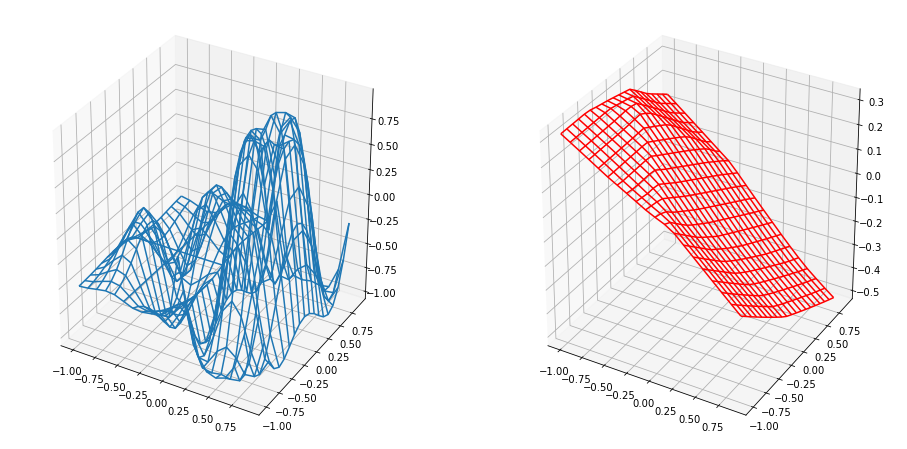

In [39]:


X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)

ax2 = fig.add_subplot(1,2,2,projection='3d')    
x1 = np.arange(-1, 1, 0.1)
x2 = np.arange(-1, 1, 0.1)
Yprime = np.zeros(Y.shape)
for i, x1_i in enumerate(x1):
    for j, x2_i in enumerate(x2):
        input_i = torch.FloatTensor([x1_i,x2_i])
        y_i = net(input_i)
        
        Yprime[j][i] = y_i
ax2.plot_wireframe(X1,X2,Yprime,color='r')


plt.show()

# Training 

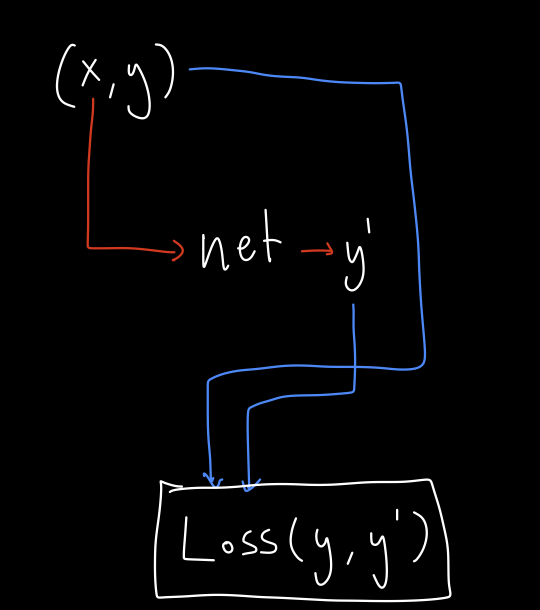

## define our loss function

In [40]:
loss_func = nn.MSELoss()

### this object, the loss function can compare our target y, and our predicted y, and return a number

if y is "closer" to y', the value of the loss is lower

In [42]:
target = torch.tensor([4.1])
prediction = torch.tensor([4.2])
loss_func(target,prediction)

tensor(0.0100)

### now we create "the optimizer"

we will talk about this in more depth later,

In [43]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.0005) 

and we run a "training loop" where the network looks at some batches of examples,
and adjusts its parameters - the goal is to lower the loss value

In [44]:
from tqdm.notebook import tqdm

for epoch in tqdm( range(20) ):
    for x,y in dataloader:
        optimizer.zero_grad()
        
        output = net(x)
        loss = loss_func(y,output)
        
        loss.backward()  
        optimizer.step()

## let's see what the network predicts now

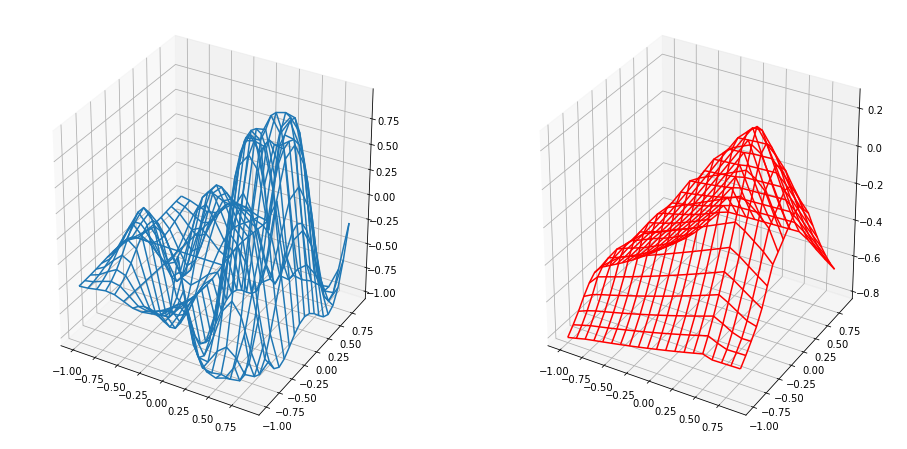

In [46]:
X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)

ax2 = fig.add_subplot(1,2,2,projection='3d')    
x1 = np.arange(-1, 1, 0.1)
x2 = np.arange(-1, 1, 0.1)
Yprime = np.zeros(Y.shape)
for i, x1_i in enumerate(x1):
    for j, x2_i in enumerate(x2):
        input_i = torch.FloatTensor([x1_i,x2_i])
        y_i = net(input_i)
        
        Yprime[j][i] = y_i
ax2.plot_wireframe(X1,X2,Yprime,color='r')


plt.show()

## let's try a neural network with a few more parameters

our last network picked up the general features of our target function, but it's not perfect

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Linear(2,100)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(100,50)
        self.layer3 = nn.Linear(50,10)
        self.layer4 = nn.Linear(10,1)
        self.activation2 = nn.Tanh()
        
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation1(out)
        out = self.layer2(out)
        out = self.activation1(out)
        out = self.layer3(out)
        out = self.activation1(out)
        out = self.layer4(out)
        out = self.activation2(out)
        
        return out
    
net = Net()

In [48]:
sum([len(p.view(-1)) for p in net.parameters()])


5871

In [49]:
net = Net()

In [50]:
optimizer = optim.Adam(net.parameters(), lr=0.01) 

In [51]:
from tqdm.notebook import tqdm

for epoch in tqdm( range(20) ):
    for x,y in dataloader:
        optimizer.zero_grad()
        
        output = net(x)
        loss = loss_func(y,output)
        
        loss.backward()  
        optimizer.step()

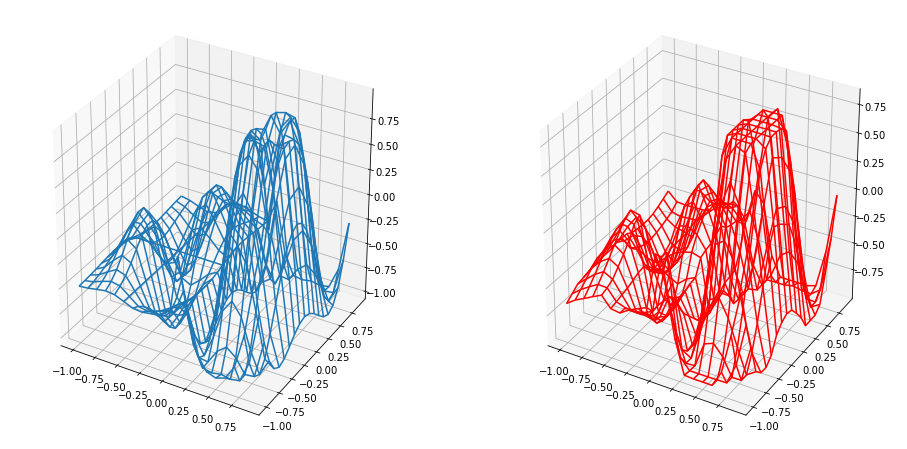

In [52]:

X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)

ax2 = fig.add_subplot(1,2,2,projection='3d')    
x1 = np.arange(-1, 1, 0.1)
x2 = np.arange(-1, 1, 0.1)
Yprime = np.zeros(Y.shape)
for i, x1_i in enumerate(x1):
    for j, x2_i in enumerate(x2):
        input_i = torch.FloatTensor([x1_i,x2_i])
        y_i = net(input_i)
        
        Yprime[j][i] = y_i
ax2.plot_wireframe(X1,X2,Yprime,color='r')


plt.show()

## lets meet a few more kinds of layers

all are documented here: https://pytorch.org/docs/stable/nn.html

In [ ]:
#Conv layer,

conv2d = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3,3))

x = torch.rand((1,3,25,25))
print('x.shape ',x.shape)

y = conv2d(x)
print('y.shape ',y.shape)

In [ ]:
x = torch.rand((1,3,256,256))
print('x.shape ',x.shape)

y = conv2d(x)
print('y.shape ',y.shape)

In [ ]:
maxpool = nn.MaxPool2d(2)

y2 = maxpool(y)
print('y2.shape ',y2.shape)

In [ ]:
convTranspose = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(3,3),dilation=5)

x = torch.rand((1,3,32,32))
print('x.shape ',x.shape)

y = convTranspose(x)
print('y.shape ',y.shape)

In [ ]:
emb = nn.Embedding(num_embeddings=5, embedding_dim=2)

In [ ]:
x = torch.LongTensor([2])

emb(x)